# 3rd experiment: Explainability and localization

Notebook for visualizing the results correponding to the 3rd experiment, between the *BU* (Bottom-Up) baselines and the corresponding *TD* (Top-Down) variants.

First, all the required files are loaded and then plots are generated.

In [1]:
import sys
sys.path.append('./../')

import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import tensorflow as tf

font_ylabel = 18
font_xlabel = 18
font_legend = 13
font_title = 18

In [2]:
# path to files
path = './../output/gradcam/'

layers = ['act_1', 'act_2', 'act_3', 'act_4']
gradcam = {}
y_pred = {}
datasets = ['MNIST', 'Fashion-MNIST']
grad_thres = np.arange(0, 1.1, 0.1)

for d in datasets:
    gradcam[d] = {}
    y_pred[d] = {}

Functions for computing the number of TP, FP, FN, TN between Grad-CAM heatmaps and thresholded objects; some other metrics are also extracted. For thresholding objects an empiricaly set thershold t=0.2 is used. For fairness only the samples correctly classified by both *BU* and *TD* networks are considered.

In [3]:
def get_metrics(x_val, y_val, gradcam, layers, y_pred, index=None):

    im_thres = 0.2
    grad_thres = np.arange(0, 1, 0.1)

    metrics = {}
    for l in layers:
        metrics[l] = {}
        UN = []
        IOU = []
        TP = []
        FP = []
        FN = []
        TN = []
        for g in grad_thres:
            un = []
            iou = []
            tp = []
            fp = []
            fn = []
            tn = []
            for i, grad in zip(range(len(gradcam)), gradcam):
                if index is not None:
                    ind = index[i]
                else:
                    ind = y_val == y_pred[i]
                inter = np.sum(np.logical_and(np.greater(grad[l][ind], g), np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2))
                un = np.sum(np.logical_or(np.greater(grad[l][ind], g), np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2))
                tp.append(inter)
                fp.append(np.sum(np.logical_and(np.greater(grad[l][ind], g), ~np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2)))
                fn.append(np.sum(np.logical_and(~np.greater(grad[l][ind], g), np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2)))
                tn.append(np.sum(np.logical_and(~np.greater(grad[l][ind], g), ~np.greater(x_val[..., 0][ind], im_thres)), axis=(0,1,2)))
                iou.append(inter/un)
            
            IOU.append(np.array(iou))
            TP.append(np.array(tp))
            FP.append(np.array(fp))
            FN.append(np.array(fn))
            TN.append(np.array(tn))
            
        IOU = np.array(IOU)
        TP = np.array(TP)
        FP = np.array(FP)
        FN = np.array(FN)
        TN = np.array(TN)

        metrics[l]['IoU'] = IOU
        metrics[l]['TP'] = TP
        metrics[l]['FP'] = FP
        metrics[l]['FN'] = FN
        metrics[l]['TN'] = TN
                          
        metrics[l]['Pr'] = TP / (TP+FP)
        metrics[l]['Rec'] = TP / (TP+FN)
        metrics[l]['F1'] = 2* (metrics[l]['Pr'] * metrics[l]['Rec'])/(metrics[l]['Pr'] + metrics[l]['Rec'])
        metrics[l]['FPR'] = FP / (FP + TN)
        
    return metrics

def BUvsTD(x_val, y_val, gradcam, gradcam_td, y_pred, y_pred_td, layers):
    
    index = np.logical_and(y_val == y_pred, y_val == y_pred_td)
    
    bu_metrics = get_metrics(x_val, y_val, gradcam, layers, y_pred, index)
    td_metrics = get_metrics(x_val, y_val, gradcam_td, layers, y_pred_td, index)
    
    return bu_metrics, td_metrics

# MNIST

In [4]:
(_, _), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_val = x_val.astype(np.float32)[..., np.newaxis]/255.0
print(x_val.shape, np.min(x_val), np.max(x_val))

(10000, 28, 28, 1) 0.0 1.0


Loading files corresponding to the *BU* and *TD* variants of NIN-light. `gradcam` are the extracted Grad-CAM heatmaps and `y_pred` the predictions made by the network.

In [5]:
model = 'NIN-light'
npzfile = np.load(f'{path}NIN_light_MNIST_gradcam.npz', allow_pickle=True)
gradcam[datasets[0]][model] = npzfile['arr_0']
y_pred[datasets[0]][model] = npzfile['arr_1']


model = 'NIN-light_TD'
npzfile = np.load(f'{path}NIN_light_TD_MNIST_gradcam.npz', allow_pickle=True)
gradcam[datasets[0]][model] = npzfile['arr_0']
y_pred[datasets[0]][model] = npzfile['arr_1']

Visualizing extracted Grad-CAM heatmaps; the first row correspond to the *BU* and the second to the *TD* network. Column 1 is the original input and columns 2-5 correspond to a different run where the model is trained from scratch. On top of each image the true and the predicted label is also given.

Grad-CAM normally uses the (rectified) features maps corresponding to the ultimate convolutional layer. We do extract heatmaps for more layers, namely `act_1`, `act_2`, `act_3` and `act_4`. Higher index "_i" means greater depth in the architecture, which means lower and higher spatial resolutions for *BU* and *TD* networks respectively.

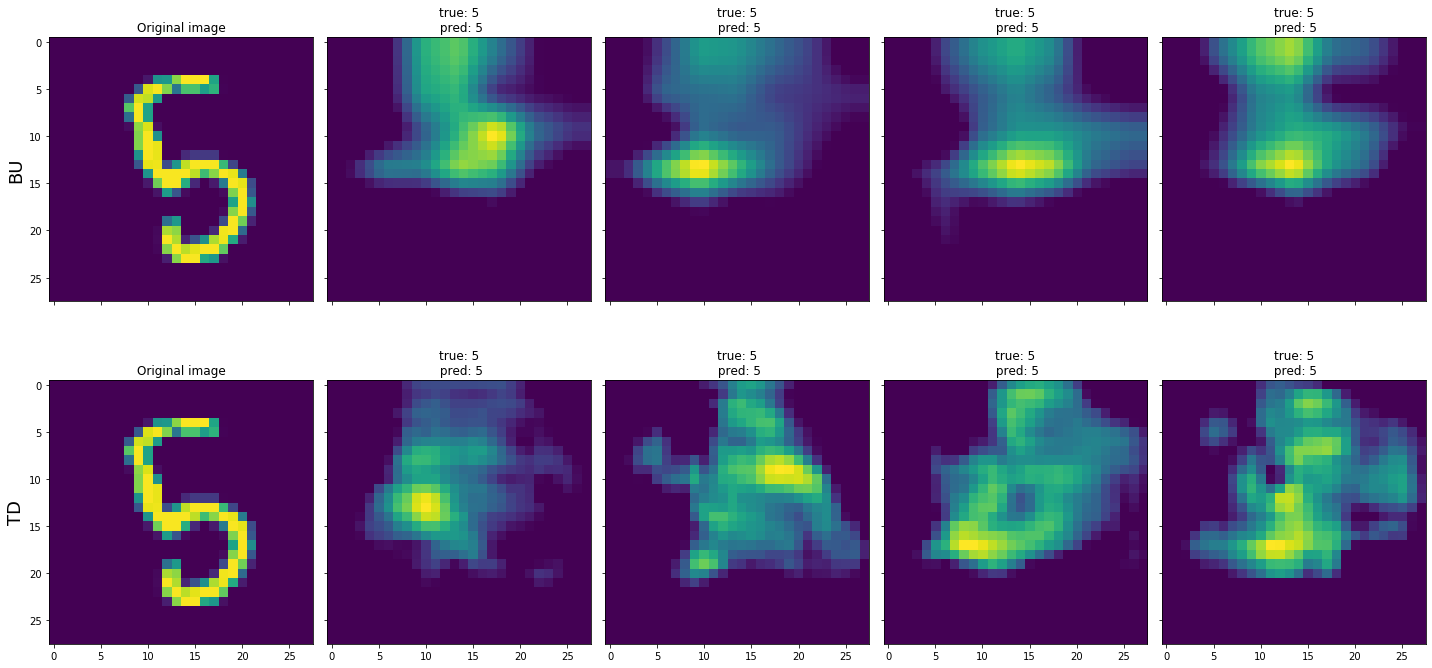

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10), sharex=True, sharey=True)

mbu = 'NIN-light'
mtd = 'NIN-light_TD'
layer = 'act_4'

ii = int(np.random.rand() * len(x_val))

ax[0,0].imshow(x_val[ii,:,:,0])
ax[0,0].set_title("Original image")
ax[1,0].imshow(x_val[ii,:,:,0])
ax[1,0].set_title("Original image")

for i in range(4):
    ax[0,i+1].imshow(gradcam[datasets[0]][mbu][i][layer][ii])
    ax[1,i+1].imshow(gradcam[datasets[0]][mtd][i][layer][ii])
    ax[0,0].set_ylabel("BU", fontsize=font_ylabel)
    ax[1,0].set_ylabel("TD", fontsize=font_ylabel)
    ax[0,i+1].set_title(f"true: {y_val[ii]}\n pred: {y_pred[datasets[0]][mbu][i][ii]}")
    ax[1,i+1].set_title(f"true: {y_val[ii]}\n pred: {y_pred[datasets[0]][mtd][i][ii]}")
fig.tight_layout()

# Fashion-MNIST

In [7]:
(_, _), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_val.astype(np.float32)[..., np.newaxis]/255.0
print(x_val.shape, np.min(x_val), np.max(x_val))
class_labels = np.array(['top', 'trouser', 'pullover', 'dress', 'coat', 
                         'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot'])

(10000, 28, 28, 1) 0.0 1.0


In [8]:
model = 'NIN-light'
npzfile = np.load(f'{path}NIN_light_FMNIST_gradcam.npz', allow_pickle=True)
gradcam[datasets[1]][model] = npzfile['arr_0']
y_pred[datasets[1]][model] = npzfile['arr_1']

model = 'NIN-light_TD'
npzfile = np.load(f'{path}NIN_light_TD_FMNIST_gradcam.npz', allow_pickle=True)
gradcam[datasets[1]][model] = npzfile['arr_0']
y_pred[datasets[1]][model] = npzfile['arr_1']

Visualizing extracted Grad-CAM heatmaps, this time for `act_1`. `act_1` corresponds to a shallow layer the *BU* filters are local, edge-detecting ones and the thus the heatmaps focus on fine details (edges) of the input. On the contrary, *TD* is focusing on coarser representations of the input.

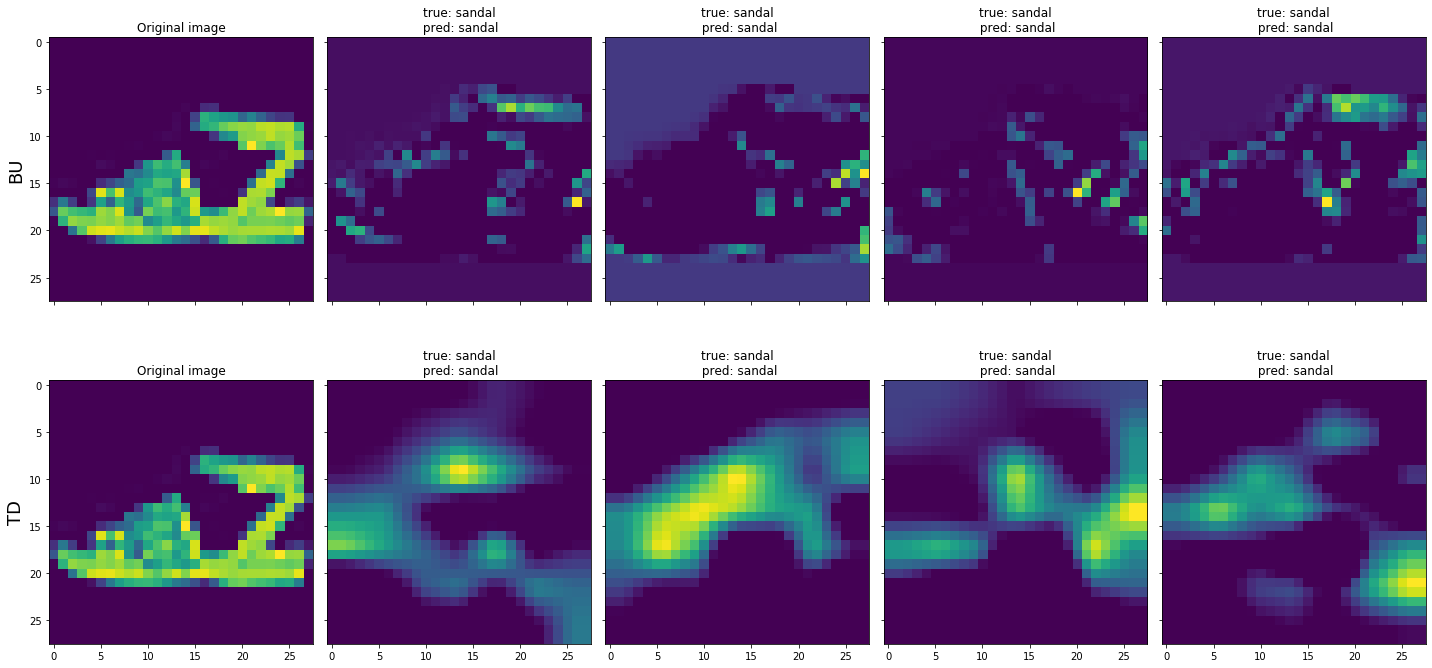

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10),sharex=True, sharey=True)

mbu = 'NIN-light'
mtd = 'NIN-light_TD'
layer = 'act_1'

ii = int(np.random.rand() * len(x_val))

ax[0,0].imshow(x_val[ii,:,:,0])
ax[1,0].imshow(x_val[ii,:,:,0])
ax[0,0].set_title("Original image")
ax[1,0].set_title("Original image")

for i in range(4):
    ax[0,i+1].imshow(gradcam[datasets[1]][mbu][i][layer][ii])
    ax[1,i+1].imshow(gradcam[datasets[1]][mtd][i][layer][ii])
    ax[0,0].set_ylabel("BU", fontsize=font_ylabel)
    ax[1,0].set_ylabel("TD", fontsize=font_ylabel)
    ax[0,i+1].set_title(f"true: {class_labels[y_val[ii]]}\n pred: {class_labels[y_pred[datasets[1]][mbu][i][ii]]}")
    ax[1,i+1].set_title(f"true: {class_labels[y_val[ii]]}\n pred: {class_labels[y_pred[datasets[1]][mtd][i][ii]]}")
fig.tight_layout()

Extract metrics for MNIST and Fashion-MNIST.

In [11]:
metrics = {}
for d in datasets:
    metrics[d] = {}
    
(_, _), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_val = x_val.astype(np.float32)[..., np.newaxis]/255.0
metrics[datasets[0]]['NIN-light'], metrics[datasets[0]]['NIN-light_TD'] = BUvsTD(x_val, y_val, 
                                                                    gradcam[datasets[0]]['NIN-light'], gradcam[datasets[0]]['NIN-light_TD'], 
                                                                    y_pred[datasets[0]]['NIN-light'], y_pred[datasets[0]]['NIN-light_TD'],
                                                                    layers)

(_, _), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_val.astype(np.float32)[..., np.newaxis]/255.0
metrics[datasets[1]]['NIN-light'], metrics[datasets[1]]['NIN-light_TD'] = BUvsTD(x_val, y_val, 
                                                                gradcam[datasets[1]]['NIN-light'], gradcam[datasets[1]]['NIN-light_TD'], 
                                                                y_pred[datasets[1]]['NIN-light'], y_pred[datasets[1]]['NIN-light_TD'],
                                                                layers)

## Plot

Computed precision and recall corresponding to the NIN-light baseline architecture aggregated over 4 runs; for each run the *BU* and *TD* models are trained from scratch. In the following plot, the first column corresponds to the computed precision and the second to the recall, whereas first and second rows hold the results for MNIST and Fashion-MNIST tasks respectively. The x-axis for each plot correpsond to the Grad-CAM threshold; note that the threshold for segregating the object from the input image is empirically set to t=0.2.

The *TD* network is more precise at its predictions. The lower recall for the Fashion-MNIST task is attributed to the higher FN. At the ultimate convolutional layer the spatial resolution matches that of the input and the network focuses on fine, informative aspects of the input. On the contrary, the coarse *BU* output captures a greater part of the input, thus leading to lower FN.

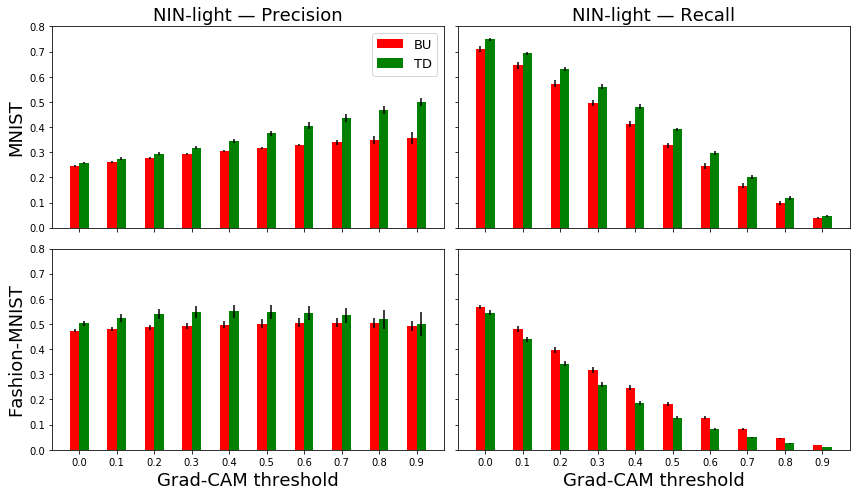

In [12]:
width = 0.25
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,7), sharey=True, sharex=True)

layer = 'act_4'
grad_thres = np.arange(0, 1, 0.1)
n = len(grad_thres)
xticks = np.round(grad_thres[:n], 1)
for i,d in zip(range(2), datasets):
    ax[i, 0].bar(np.arange(n)-0.5*width, np.mean(metrics[d]['NIN-light'][layer]['Pr'][:n], axis=-1),
                yerr=np.std(metrics[d]['NIN-light'][layer]['Pr'][:n], axis=-1, ddof=1), width=width,
                label='BU', color='r')
    ax[i, 0].bar(np.arange(n)+0.5*width, np.mean(metrics[d]['NIN-light_TD'][layer]['Pr'][:n], axis=-1),
                yerr=np.std(metrics[d]['NIN-light_TD'][layer]['Pr'][:n], axis=-1, ddof=1), width=width,
                label='TD', color='g')
    ax[i,0].set_xticks(np.arange(n))
    ax[i,0].set_xticklabels(xticks)
    ax[i, 0].set_ylim(0,0.8)
    
    ax[i, 1].bar(np.arange(n)-0.5*width, np.mean(metrics[d]['NIN-light'][layer]['Rec'][:n], axis=-1),
                yerr=np.std(metrics[d]['NIN-light'][layer]['Rec'][:n], axis=-1, ddof=1), width=width,
                label='BU', color='r')
    ax[i, 1].bar(np.arange(n)+0.5*width, np.mean(metrics[d]['NIN-light_TD'][layer]['Rec'][:n], axis=-1),
                yerr=np.std(metrics[d]['NIN-light_TD'][layer]['Rec'][:n], axis=-1, ddof=1), width=width,
                label='TD', color='g')
    ax[i,1].set_xticks(np.arange(n))
    ax[i,1].set_xticklabels(xticks)
    ax[i, 1].set_ylim(0,0.8)
    
ax[0,0].set_ylabel(f"MNIST", fontsize=font_ylabel)
ax[1,0].set_ylabel("Fashion-MNIST", fontsize=font_ylabel)
ax[0,0].set_title("NIN-light \u2014 Precision", fontsize=font_title)
ax[0,1].set_title("NIN-light \u2014 Recall", fontsize=font_title)
ax[1,0].set_xlabel("Grad-CAM threshold", fontsize=font_xlabel)
ax[1,1].set_xlabel("Grad-CAM threshold", fontsize=font_xlabel)
ax[0,0].legend(fontsize=font_legend)

fig.tight_layout()

# Imagenette

In [3]:
from download_imagenette import ImagenetteGenerator

root_dir = './../data/imagenette2/'
layers = np.array(['act_1', 'act_2', 'act_3', 'act_4', 'act_5'])
if os.path.exists(root_dir + "train/data.npz"):
    npzfile = np.load(root_dir + "train/data.npz", allow_pickle=True)
    x_train = npzfile['arr_0']
    y_train = npzfile['arr_1']
if os.path.exists(root_dir + "val/data.npz"):
    npzfile = np.load(root_dir + "val/data.npz", allow_pickle=True)
    x_val = npzfile['arr_0']
    y_val = npzfile['arr_1']
    class_mapping = npzfile['arr_2'].item()


A set of validation samples, along with their corresponding labels.

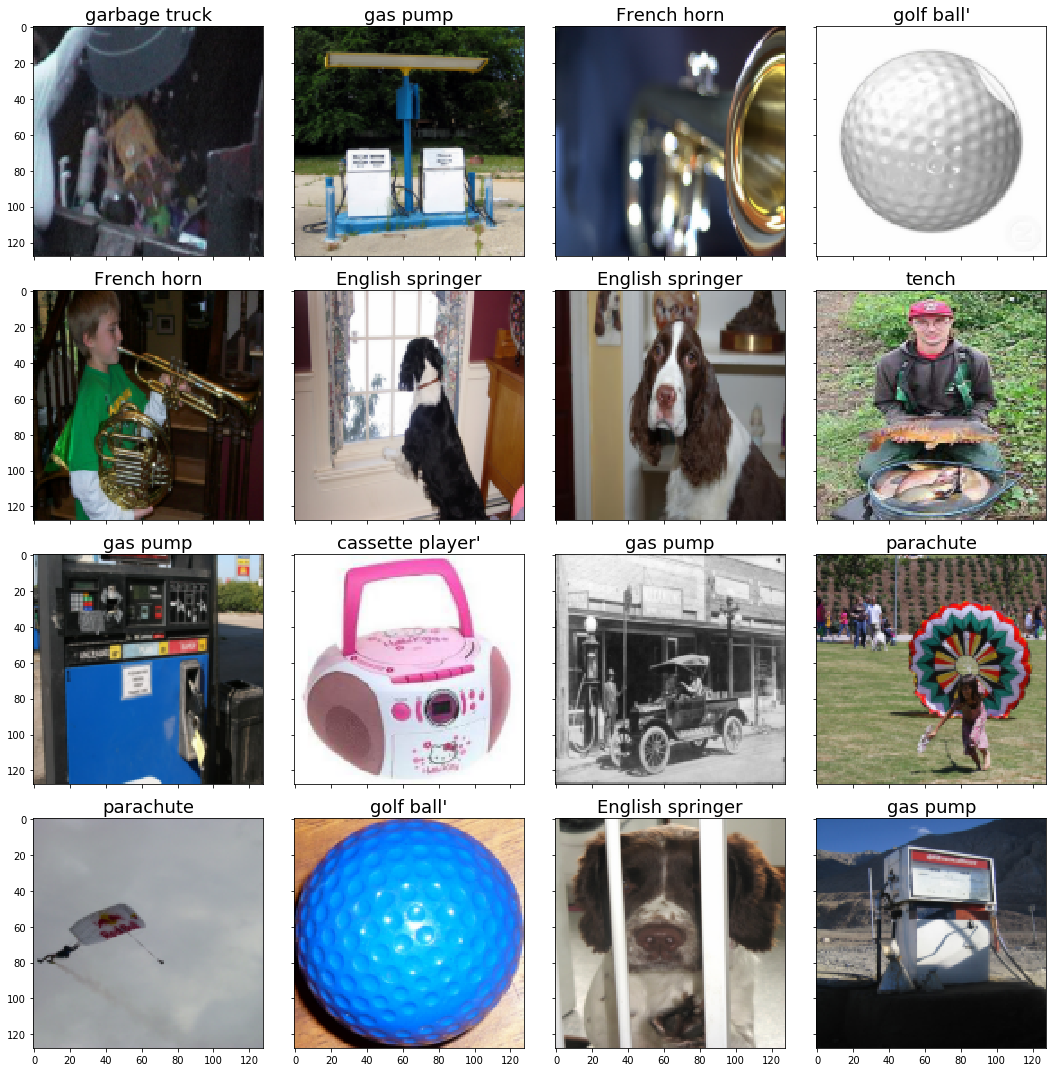

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15), sharex=True, sharey=True)
ind = np.random.choice(len(x_val), 16, replace=False)

for i in range(4):
    for j in range(4):
        ax[i,j].imshow(x_val[ind[j+4*i]])
        ax[i,j].set_title(class_mapping[y_val[ind[j+4*i]]], fontsize=font_title)
fig.tight_layout()

Loading files.

In [5]:
npzfile = np.load(f'{path}ResNet18_IMAGENETTE_gradcam.npz', allow_pickle=True)
gradcam = npzfile['arr_0'].item()
y_pred = npzfile['arr_1']

npzfile = np.load(f'{path}ResNet18Cat_foo_2_IMAGENETTE_gradcam.npz', allow_pickle=True)
gradcam_td = npzfile['arr_0'].item()
y_pred_td = npzfile['arr_1']

Grad-CAM heatmaps corresponding to a lighter ResNet18 trained on Imagenette dataset. The first, second row corresponds to *BU* and *TD* heatmaps respectively. Layer 1 corresponds to the activation of the input to the first group of residual blocks, whereas Layer 2 - 5 to the activation of the output of each of these four groups of blocks, each one corresponding to a different spatial resolution.

Clearly, the *BU* baseline moves from finer to coarser representations of the input. The *TD* network follows the exactly opposite path.

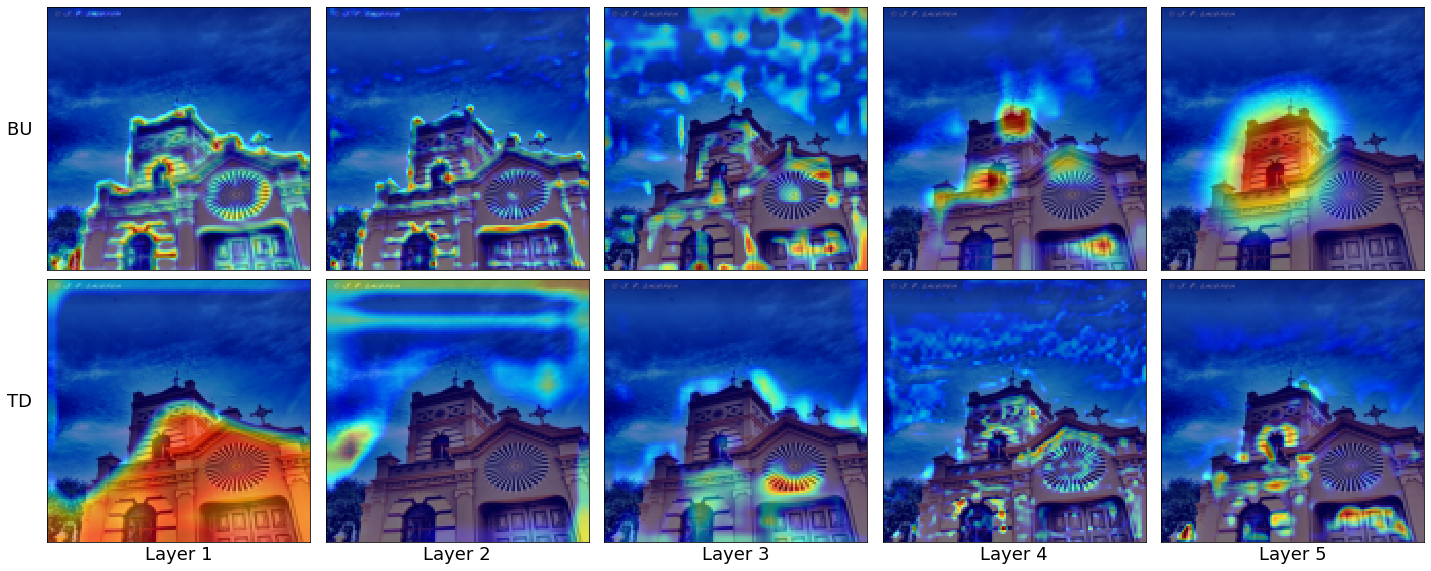

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=len(layers), figsize=(20, 8), sharex=True, sharey=True)

# ii = int(np.random.rand() * len(x_val))
ii = 1875
for i in range(len(layers)):
    cam = cv2.applyColorMap(np.uint8(255 * gradcam[layers[i]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[0, i].imshow(np.uint8(cam))
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])

    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam_td[layers[i]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[1, i].imshow(np.uint8(cam))
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1, i].set_xlabel(f"Layer {i+1}", fontsize=font_xlabel)
    
# ax[0, 0].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred[ii]]}", fontsize=font_title)
# ax[1, 0].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred_td[ii]]}", fontsize=font_title)
ax[0,0].set_ylabel('BU        ', fontsize=font_ylabel, rotation=0)
ax[1,0].set_ylabel('TD        ', fontsize=font_ylabel, rotation=0)

fig.tight_layout()

Grad-CAM heatmaps correpsonding to the ultimate convolutional layer (Layer-5). The first row shows the input images, whereas the 2nd and 3rd the corresponding heatmaps for the *BU* and *TD* networks respectively.

Notice, the coarse versus fine output for *BU* and *TD* networks respectively. The *TD* network focuses on fine, informative aspects for the classification (e.g. the cross for the church at the fourth column). 

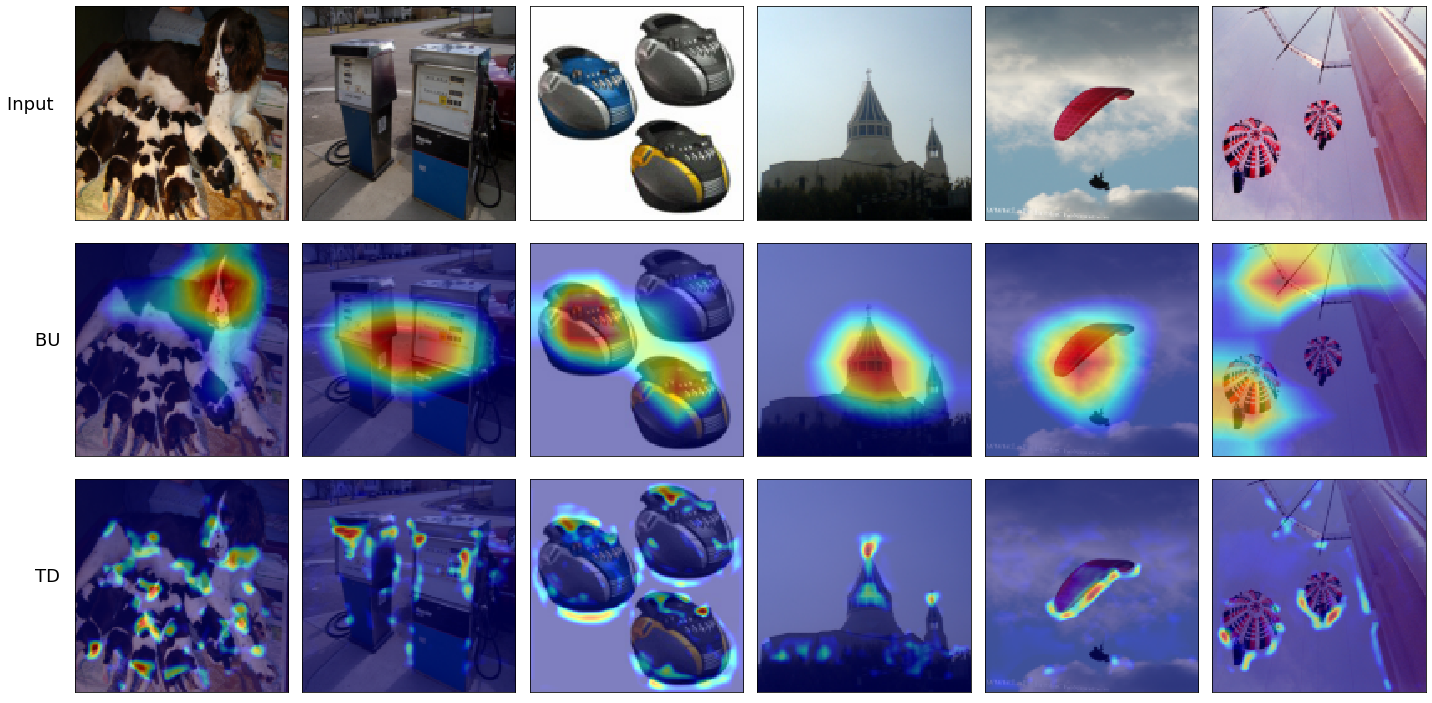

In [7]:
inds=[648, 3081, 913, 1847, 3897, 3707]
fig, ax = plt.subplots(nrows=3, ncols=len(inds), figsize=(20, 10), sharex=True, sharey=True)

for i, ii in zip(range(len(inds)), inds):
    ax[0,i].imshow(x_val[ii])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam[layers[-1]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[1, i].imshow(np.uint8(cam))
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam_td[layers[-1]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[2, i].imshow(np.uint8(cam))
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    
#     ax[1, i].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred[ii]]}")
#     ax[2, i].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred_td[ii]]}")
# ax[0,0].set_ylabel("Input            ", fontsize=font_ylabel, rotation=0)
ax[0,0].set_ylabel('Input              ', fontsize=font_ylabel, rotation=0)
ax[1,0].set_ylabel('BU        ', fontsize=font_ylabel, rotation=0)
ax[2,0].set_ylabel('TD        ', fontsize=font_ylabel, rotation=0)

fig.tight_layout()

More Grad-CAM heatmaps. The fine *TD* output and the promising localization results from our MNIST, Fashion-MNIST experiment, pose the weakly-supervised segmentation setting a potential domain where *TD* networks could shine.

[1564 3904 3271  551 1552  787]


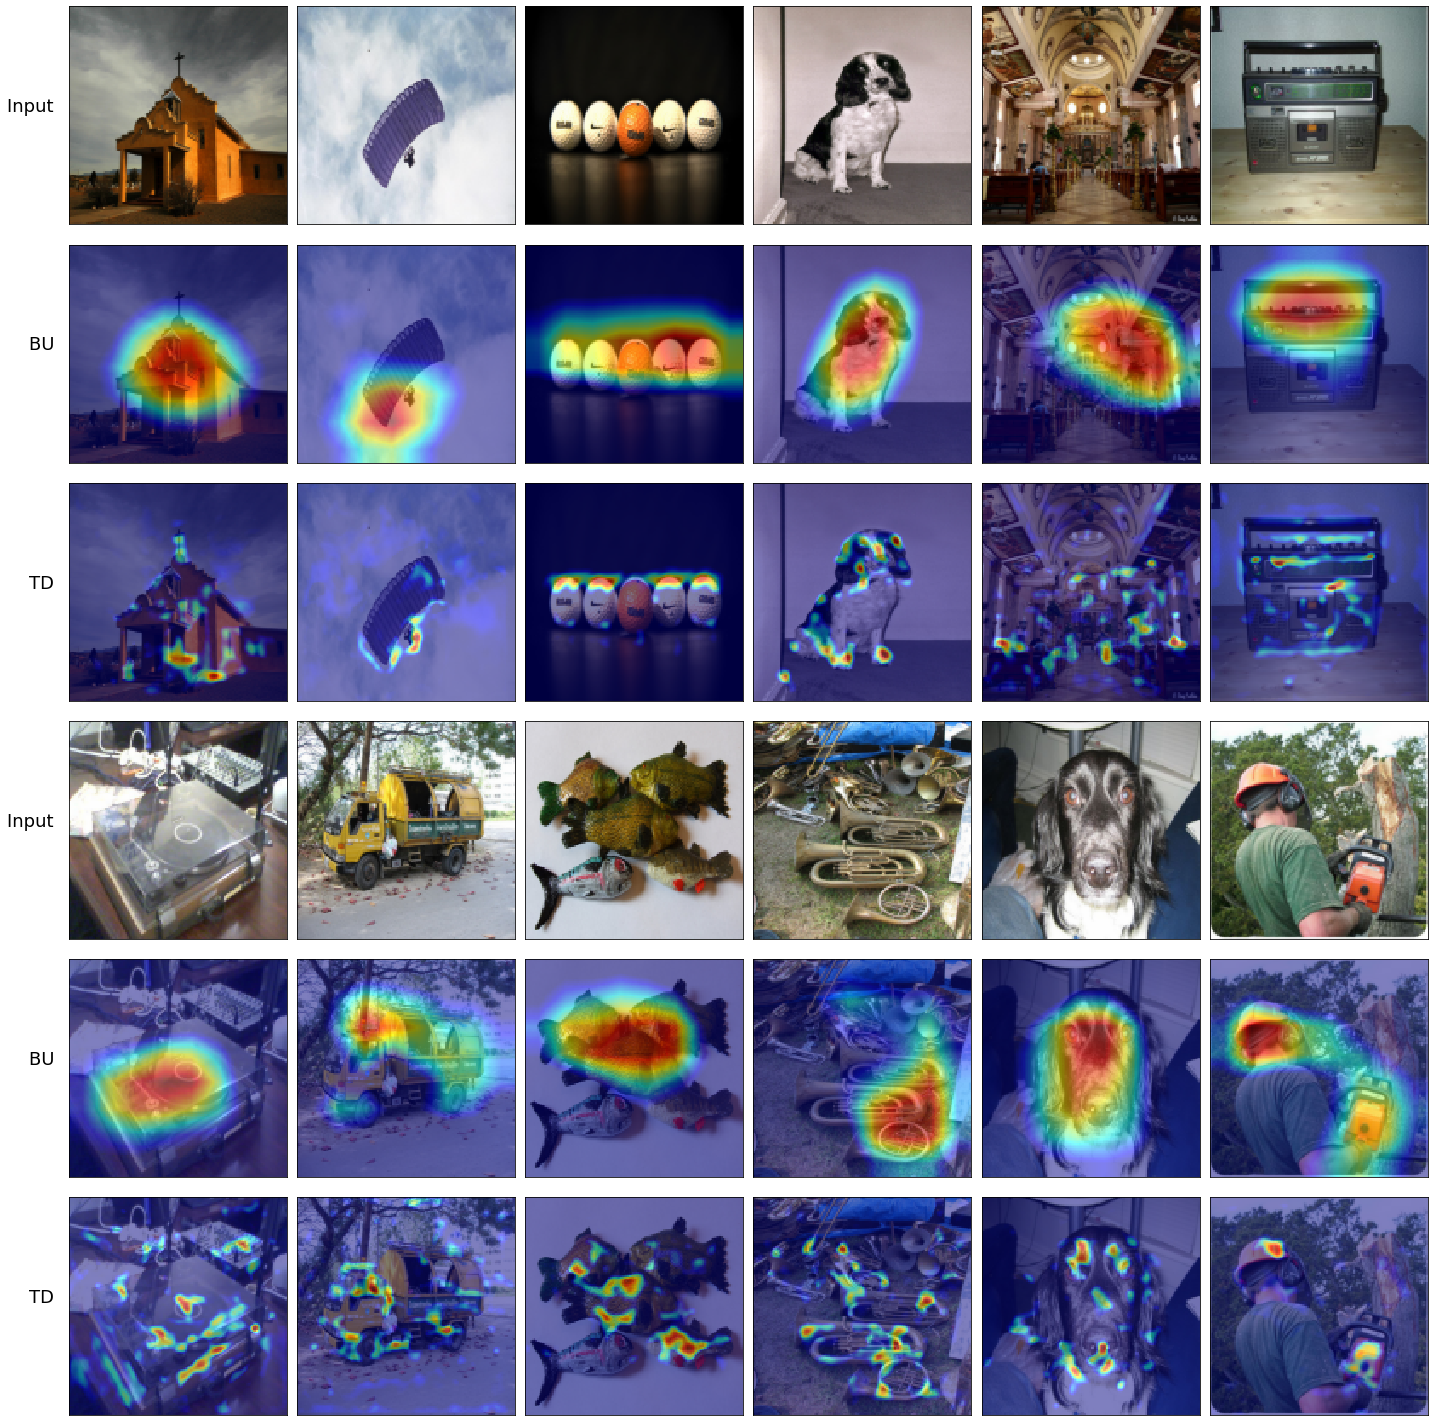

In [8]:
# inds=np.random.choice(len(x_val), 6, replace=False)
inds = np.array([1564, 3904, 3271, 551, 1552, 787])
print(inds)
fig, ax = plt.subplots(nrows=6, ncols=len(inds), figsize=(20, 20), sharex=True, sharey=True)

for i, ii in zip(range(len(inds)), inds):
    ax[0,i].imshow(x_val[ii])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam[layers[-1]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[1, i].imshow(np.uint8(cam))
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam_td[layers[-1]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[2, i].imshow(np.uint8(cam))
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    
#     ax[1, i].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred[ii]]}")
#     ax[2, i].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred_td[ii]]}")
ax[0,0].set_ylabel("Input            ", fontsize=font_ylabel, rotation=0)
ax[1,0].set_ylabel('BU        ', fontsize=font_ylabel, rotation=0)
ax[2,0].set_ylabel('TD        ', fontsize=font_ylabel, rotation=0)

inds = np.array([1031, 2527, 292, 2025, 582, 1489])
for i, ii in zip(range(len(inds)), inds):
    ax[3,i].imshow(x_val[ii])
    ax[3,i].set_xticks([])
    ax[3,i].set_yticks([])
    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam[layers[-1]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[4, i].imshow(np.uint8(cam))
    ax[4,i].set_xticks([])
    ax[4,i].set_yticks([])

    
    cam = cv2.applyColorMap(np.uint8(255 * gradcam_td[layers[-1]][ii]), cv2.COLORMAP_JET)
    cam = (np.flip(np.float32(cam), axis=-1) + 255*np.float32(x_val[ii]))/2
    ax[5, i].imshow(np.uint8(cam))
    ax[5,i].set_xticks([])
    ax[5,i].set_yticks([])
    
#     ax[4, i].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred[ii]]}")
#     ax[5, i].set_title(f"true: {class_mapping[y_val[ii]]}\n pred: {class_mapping[y_pred_td[ii]]}")
ax[3,0].set_ylabel("Input            ", fontsize=font_ylabel, rotation=0)
ax[4,0].set_ylabel('BU        ', fontsize=font_ylabel, rotation=0)
ax[5,0].set_ylabel('TD        ', fontsize=font_ylabel, rotation=0)

fig.tight_layout()